# Getting started

Once you've chosen your scenario, download the data from [the Iowa website](https://data.iowa.gov/Economy/Iowa-Liquor-Sales/m3tr-qhgy) in csv format. Start by loading the data with pandas. You may need to parse the date columns appropriately.

In [1]:
import pandas as pd
import datetime
import numpy as np

In [2]:
## Load the data into a DataFrame
df = pd.read_csv("../../../../iowa_data/Iowa_Liquor_sales_sample_10pct.csv")

## Transform the dates if needed, e.g.
df["Date"] = pd.to_datetime(df["Date"])

# Remove redundant columns
df.drop("Volume Sold (Gallons)", axis = 1, inplace = True)


# Remove $ from certain columns
dcs = ["State Bottle Cost", "State Bottle Retail", "Sale (Dollars)"]
for col in dcs:
    df[col] = df[col].map(lambda x: float(x.lstrip('$')))

# Create a column for month and year
df["Year"] = df["Date"].dt.year
df["Month"] = df["Date"].dt.month

# Create a column for profits earned by every transaction
df['Profit'] = (df["State Bottle Retail"] - df["State Bottle Cost"]) * df["Bottles Sold"]

In [3]:
# Replace random Zipcode with actual value and change to int types
df['Zip Code'].replace('712-2', '51529', inplace = True)
df['Zip Code'] = df['Zip Code'].astype(int, copy = True)

In [4]:
# Create Price Per Liter column
df['Price Per Liter'] = df['State Bottle Retail']/(df["Bottle Volume (ml)"]/1000)
df['Price Per Liter'] = df['Price Per Liter'].round(2)

In [5]:
# Function that assigns quarter to the transaction and create column for Quarter
def quarter_assigner(x):
    if x <= 3:
        return 1
    elif x <= 6:
        return 2
    elif x <= 9:
        return 3
    else:
        return 4
    
df['Quarter'] = df['Month'].map(quarter_assigner)

In [6]:
# Do Not Run. It takes more than an hour

# # FILLING IN ALL MY NANs

# for group_label, group_df in df.groupby(["Zip Code", "Item Number"]): 
#     mask = (df['Zip Code'] == group_label[0]) & (df["Item Number"] == group_label[1])
#     df[mask] = df[mask].sort(["County", "Category"]).ffill()

In [7]:
# Drop stores with no values
df.dropna(how = "any", axis = 0, inplace= True)

# Deleting liquors that are were only sold 2 times
beer_mask = df['Category Name'] == 'HIGH PROOF BEER - AMERICAN'
df[beer_mask]
df.drop(df[beer_mask].index, axis = 0, inplace = True)

In [8]:
# """For blog explaining purposes"""

# # FILLING IN ALL MY NULLS
# dfc = df.head(550)
# # Use interpolate and ffill to fill in nans 

# # df["Item Number", "Category"].interpolate(method = 'linear', inplace = True, limit_direction = 'both')

# for group_label, group_df in df.groupby(["Zip Code", "Item Number"]): 
#     mask = (df['Zip Code'] == group_label[0]) & (df["Item Number"] == group_label[1])
#     df[mask] = df[mask].sort(["County", "Category"]).ffill()


In [9]:
# dfc.info()

In [10]:
# # """TEST TO SEE IF CATEGORIES AND ITEM NUMBERS MATCH 1 TO 1"""
# tester = dfc.groupby(["Item Number", "Category"])["Profit"].sum()
# print len(dfc['Item Number'].unique())
# print tester.shape

In [11]:
# Creates a column called Transactions containing the total number of transactions for each store

# dfc = df.copy()

# trans = dfc['Store Number'].value_counts()
# trans = pd.DataFrame(trans).reset_index().rename(columns = {'index': 'Store Number', 'Store Number': 'Transactions'})

# dfc = pd.merge(dfc, trans, how = 'inner', on = 'Store Number')

# dfc.head()

In [12]:
# # Subset for each store based on quarter of sales in 2015 alone
# quarter_subset = sales[sales.Year == 0].groupby(['Store Number', 'Quarter'])['Profit'].sum()
# quarter_subset = pd.DataFrame(quarter_subset).reset_index()
# quarter_subset.head()

# Explore the data

Perform some exploratory statistical analysis and make some plots, such as histograms of transaction totals, bottles sold, etc.

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

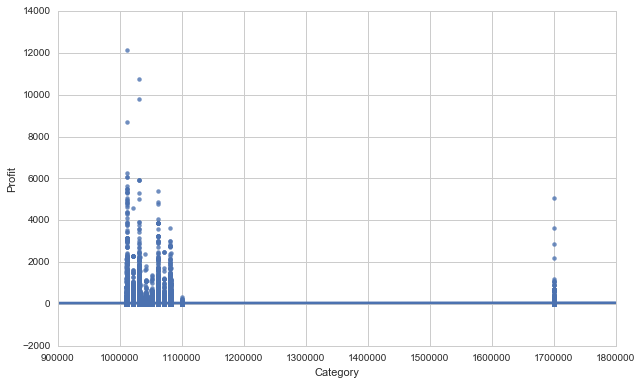

In [19]:
sns.regplot(x = "Category", y = "Profit", data = df, scatter=True)

/Users/Tami/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  app.launch_new_instance()


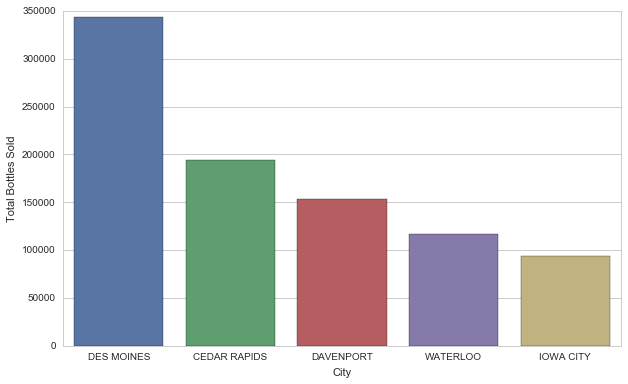

In [15]:
subset = df.groupby('City')["Bottles Sold"].sum()
subsetdf = pd.DataFrame(subset).reset_index()
bottles_sub_set = subsetdf.sort('Bottles Sold', ascending = False).head(5)

sns.set(rc= {"figure.figsize" : (10,6)}, style = "whitegrid")
ax = sns.barplot(x = "City", y= "Bottles Sold", data = bottles_sub_set)
ax.set(xlabel = "City", ylabel = "Total Bottles Sold")

plt.show()

In [16]:
bottles_sub_set

,City,Bottles Sold
90,DES MOINES,344151
51,CEDAR RAPIDS,194525
81,DAVENPORT,153200
358,WATERLOO,117206
175,IOWA CITY,93923


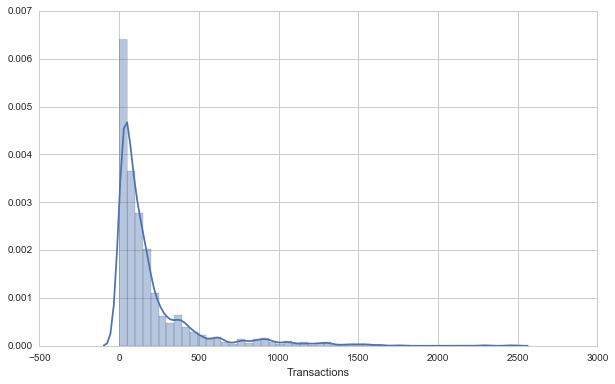

In [17]:
transactions = df["Store Number"].value_counts()
transactions = pd.DataFrame(transactions).reset_index().rename(columns = {'index': 'Store Number',
                                                                          'Store Number' : 'Transactions'})
sns.distplot(transactions['Transactions'])

## Record your findings

Be sure to write out anything observations from your exploratory analysis.

Top 5 Cities based on Bottles Sold:
 * Des Moines
 * Cedar Rapids
 * Davenport
 * Waterloo
 * Iowa City

Top 5 Cities based on Total Profits in dataset:
 * Des Moines
 * Cedar Rapids
 * Davenport
 * Iowa City
 * Sioux City

# Mine the data
Now you are ready to compute the variables you will use for your regression from the data. For example, you may want to
compute total sales per store from Jan to March of 2015, mean price per bottle, etc. Refer to the readme for more ideas appropriate to your scenario.

Pandas is your friend for this task. Take a look at the operations [here](http://pandas.pydata.org/pandas-docs/stable/groupby.html) for ideas on how to make the best use of pandas and feel free to search for blog and Stack Overflow posts to help you group data by certain variables and compute sums, means, etc. You may find it useful to create a new data frame to house this summary data.

In [20]:
modeling_copy = df.copy()

In [21]:
# Generalizing categories
for x in modeling_copy['Category Name']:
    if 'WHISK' in str(x):
        modeling_copy['Category Name'].replace(x, 'Whisky', inplace = True)
    elif 'BRAND' in str(x):
        modeling_copy['Category Name'].replace(x, 'Brandy', inplace = True)
    elif 'COCKTAIL' in str(x):
        modeling_copy['Category Name'].replace(x, 'Cocktail', inplace = True)
    elif 'VODKA' in str(x):
        modeling_copy['Category Name'].replace(x, 'Vodka', inplace = True)
    elif 'GIN' in str(x):
        modeling_copy['Category Name'].replace(x, 'Gin', inplace = True)
    elif 'SCHNAP' in str(x):
        modeling_copy['Category Name'].replace(x, 'Brandy', inplace = True)
    elif 'LIQUEUR' in str(x):
        modeling_copy['Category Name'].replace(x, 'Liqueur', inplace = True)
    elif 'TRIPLE SEC' in str(x):
        modeling_copy['Category Name'].replace(x, 'Liqueur', inplace = True)
    elif 'ANISETTE' in str(x):
        modeling_copy['Category Name'].replace(x, 'Liqueur', inplace = True)
    elif 'TEQUILA' in str(x):
        modeling_copy['Category Name'].replace(x, 'Tequila', inplace = True)
    elif 'BOURBON' in str(x):
        modeling_copy['Category Name'].replace(x, 'Whisky', inplace = True)
    elif 'SCOTCH' in str(x):
        modeling_copy['Category Name'].replace(x, 'Whisky', inplace = True)
    elif 'RUM' in str(x):
        modeling_copy['Category Name'].replace(x, 'Rum', inplace = True)
    elif 'AMARETTO' in str(x):
        modeling_copy['Category Name'].replace(x, 'Amaretto', inplace = True)
    elif 'ROCK & RYE' in str(x):
        modeling_copy['Category Name'].replace(x, 'Whisky', inplace = True)
    elif 'CREME DE' in str(x):
        modeling_copy['Category Name'].replace(x, 'Mixer', inplace = True)
    elif 'AMERICAN ALCOHOL' in str(x):
        modeling_copy['Category Name'].replace(x, 'Misc.', inplace = True)
    elif 'DECANTER' in str(x):
        modeling_copy['Category Name'].replace(x, 'Decanter', inplace = True)
    elif 'SPECIALTY' in str(x):
        modeling_copy['Category Name'].replace(x, 'Specialties', inplace = True)

modeling_copy['Category Name'].unique()

array(['Brandy', 'Whisky', 'Cocktail', 'Vodka', 'Gin', 'Specialties',
       'Tequila', 'Liqueur', 'Rum', 'Amaretto', 'Misc.', 'Decanter',
       'Mixer'], dtype=object)

In [22]:
# Use interpolate and ffill to fill in nans 
for group_label, group_df in modeling_copy.groupby("Zip Code"):
    modeling_copy[modeling_copy["Zip Code"] == group_label] = modeling_copy[modeling_copy["Zip Code"] == group_label].sort("County Number").ffill()
    
modeling_copy.interpolate(method = 'linear', inplace = True, limit_direction = 'both')

/Users/Tami/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  app.launch_new_instance()


In [23]:
# Category Number column for every generalized category
cats = sorted(modeling_copy['Category Name'].unique())
cats_list = list(enumerate(cats, start=1))

lt = []
for cats in modeling_copy['Category Name']:
    for x in cats_list:
        if x[1] == cats:
            lt.append(x[0])
modeling_copy['Category Number'] = lt

modeling_copy.head()


,Date,Store Number,City,Zip Code,County Number,County,Category,Category Name,Vendor Number,Item Number,...,State Bottle Retail,Bottles Sold,Sale (Dollars),Volume Sold (Liters),Year,Month,Profit,Price Per Liter,Quarter,Category Number
0,2015-11-04,3717,SUMNER,50674,9.0,Bremer,1051100.0,Brandy,55,54436,...,6.75,12,81.00,9.0,2015,11,27.00,9.00,4,2
1,2016-03-02,2614,DAVENPORT,52807,82.0,Scott,1011100.0,Whisky,395,27605,...,20.63,2,41.26,1.5,2016,3,13.76,27.51,1,13
2,2016-02-11,2106,CEDAR FALLS,50613,7.0,Black Hawk,1011200.0,Whisky,65,19067,...,18.89,24,453.36,24.0,2016,2,151.20,18.89,1,13
3,2016-02-03,2501,AMES,50010,85.0,Story,1071100.0,Cocktail,395,59154,...,14.25,6,85.50,10.5,2016,2,28.50,8.14,1,3
4,2015-08-18,3654,BELMOND,50421,99.0,Wright,1031080.0,Vodka,297,35918,...,10.80,12,129.60,21.0,2015,8,43.20,6.17,3,12


In [24]:
# Determine which stores were open all of 2015
mask1 = modeling_copy.Year == 2015

first_sale_date = modeling_copy[mask1].groupby(['Store Number'])['Date'].min()
last_sale_date = modeling_copy[mask1].groupby(['Store Number'])['Date'].max()
# Filter out stores that opened or closed throughout the year
# first_sale_date

first_sale_df = pd.DataFrame(first_sale_date).reset_index()
last_sale_df = pd.DataFrame(last_sale_date).reset_index()

mask2 = [first_sale_df.Date[i].month == 1 for i in range(len(first_sale_df))]
mask3 = [last_sale_df.Date[i].month == 12 for i in range(len(first_sale_df))]

jan_stores = first_sale_df[mask2]['Store Number']
dec_stores = last_sale_df[mask3]['Store Number']

full_year_stores_mask = jan_stores.isin(dec_stores)
full_year_stores = jan_stores[full_year_stores_mask]

final_mask = modeling_copy['Store Number'].isin(full_year_stores)
sales_both = modeling_copy[final_mask]

sales_both.head()

,Date,Store Number,City,Zip Code,County Number,County,Category,Category Name,Vendor Number,Item Number,...,State Bottle Retail,Bottles Sold,Sale (Dollars),Volume Sold (Liters),Year,Month,Profit,Price Per Liter,Quarter,Category Number
0,2015-11-04,3717,SUMNER,50674,9.0,Bremer,1051100.0,Brandy,55,54436,...,6.75,12,81.00,9.0,2015,11,27.00,9.00,4,2
1,2016-03-02,2614,DAVENPORT,52807,82.0,Scott,1011100.0,Whisky,395,27605,...,20.63,2,41.26,1.5,2016,3,13.76,27.51,1,13
2,2016-02-11,2106,CEDAR FALLS,50613,7.0,Black Hawk,1011200.0,Whisky,65,19067,...,18.89,24,453.36,24.0,2016,2,151.20,18.89,1,13
3,2016-02-03,2501,AMES,50010,85.0,Story,1071100.0,Cocktail,395,59154,...,14.25,6,85.50,10.5,2016,2,28.50,8.14,1,3
4,2015-08-18,3654,BELMOND,50421,99.0,Wright,1031080.0,Vodka,297,35918,...,10.80,12,129.60,21.0,2015,8,43.20,6.17,3,12


In [26]:
q1_15_mask = (sales_both.Month <= 3) & (sales_both.Month >= 1) & (sales_both.Year == 2015)
q1_16_mask = (sales_both.Month <= 3) & (sales_both.Month >= 1) & (sales_both.Year == 2016)
all_15_mask = sales_both.Year == 2015
all_16_mask = sales_both.Year == 2016

q1_15_stores = sales_both[q1_15_mask]
q1_16_stores = sales_both[q1_16_mask]
all_15_stores = sales_both[all_15_mask]

In [27]:
# Subset of Store Number and respective County Number
counties = sales_both.groupby(['Store Number', 'County Number'])
store_cats = counties['Store Number', 'County Number'].head(1).sort_values(by = 'Store Number', ascending = True)
store_cats.head()

,Store Number,County Number
2,2106,7.0
3893,2113,94.0
16,2130,7.0
4795,2152,17.0
469,2178,3.0


In [28]:
# Create a subset with the average profit for each category FOR 2015
avg_profit_cats15 = sales_both[all_15_mask].groupby(['Store Number', 'Category Number'])['Profit'].mean()
avg_profit_cats15 = pd.DataFrame(avg_profit_cats15).reset_index()

# Selecting the category with the max avg profit for each store
max_cats15 = avg_profit_cats15.loc[avg_profit_cats15.reset_index().groupby(['Store Number'])['Profit'].idxmax()]
max_cats15.drop('Profit', axis = 1, inplace = True)
max_cats15.head()

,Store Number,Category Number
7,2106,9
17,2113,9
28,2130,9
39,2152,9
48,2178,9


In [29]:
# Create a subset with the average profit for each category FOR 2016
avg_profit_cats16 = sales_both[all_16_mask].groupby(['Store Number', 'Category Number'])['Profit'].mean()
avg_profit_cats16 = pd.DataFrame(avg_profit_cats16).reset_index()

# Selecting the category with the max avg profit for each store
max_cats16 = avg_profit_cats16.loc[avg_profit_cats16.reset_index().groupby(['Store Number'])['Profit'].idxmax()]
max_cats16.drop('Profit', axis = 1, inplace = True)
max_cats16.head()

,Store Number,Category Number
6,2106,9
17,2113,13
24,2130,12
30,2152,13
36,2178,7


In [30]:
# Creating a subset with the average profit for each category.
avg_ppl15 = sales_both[all_15_mask].groupby(['Store Number'])['Price Per Liter'].mean()
avg_ppl15 = pd.DataFrame(avg_ppl15).reset_index()
avg_ppl15['Price Per Liter'] = avg_ppl15['Price Per Liter'].round(2)

avg_ppl15.head()

,Store Number,Price Per Liter
0,2106,17.85
1,2113,18.50
2,2130,16.82
3,2152,13.02
4,2178,16.06


In [31]:
# Creating a subset with the average profit for each category.
avg_ppl16 = sales_both[all_16_mask].groupby(['Store Number'])['Price Per Liter'].mean()
avg_ppl16 = pd.DataFrame(avg_ppl16).reset_index()
avg_ppl16['Price Per Liter'] = avg_ppl16['Price Per Liter'].round(2)

avg_ppl16.head()

,Store Number,Price Per Liter
0,2106,17.97
1,2113,17.48
2,2130,17.45
3,2152,12.49
4,2178,15.10


In [32]:
# Subset that will become a column of the total profits per store for Q1 of 2015
q1_15_profits = q1_15_stores.groupby(['Store Number'])['Profit', 'Sale (Dollars)'].sum()
q1_15_profits = pd.DataFrame(q1_15_profits).reset_index().sort_values(by = 'Store Number', ascending = True)

# Subset that will become a column of the total profits per store for Q1 of 2016
q1_16_profits = q1_16_stores.groupby(['Store Number'])['Profit','Sale (Dollars)'].sum()
q1_16_profits = pd.DataFrame(q1_16_profits).reset_index().sort_values(by = 'Store Number', ascending = True)

# Subset of total profits for 2015
all_15_profits = all_15_stores.groupby(['Store Number'])['Profit','Sale (Dollars)'].sum()
all_15_profits = pd.DataFrame(all_15_profits).reset_index().sort_values(by = 'Store Number', ascending = True)

In [33]:
# Creating dataframes per quarter of 2015 to calculate growth rate and predict 2016

# Creating masks for other 3 quarters
q2_15_mask = (sales_both.Year == 2015) & (sales_both.Month >= 4) & (sales_both.Month <= 6)
q3_15_mask = (sales_both.Year == 2015) & (sales_both.Month >= 7) & (sales_both.Month <= 9)
q4_15_mask = (sales_both.Year == 2015) & (sales_both.Month >= 10) & (sales_both.Month <= 12)

# Grouping each quarter
q2_15_profit = sales_both[q2_15_mask].groupby(["Store Number"])['Profit', 'Sale (Dollars)'].sum()
q3_15_profit = sales_both[q3_15_mask].groupby(['Store Number'])['Profit', 'Sale (Dollars)'].sum()
q4_15_profit = sales_both[q4_15_mask].groupby(['Store Number'])['Profit', 'Sale (Dollars)'].sum()

# Turning groupby df into a df
q2_15_profit = pd.DataFrame(q2_15_profit).reset_index()
q3_15_profit = pd.DataFrame(q3_15_profit).reset_index()
q4_15_profit = pd.DataFrame(q4_15_profit).reset_index()

# Renaming column titles before merging dfs
q2_15_profit = q2_15_profit.rename(columns = {'Profit':'Q2 Profit','Sale (Dollars)': 'Q2 Sales'})
q3_15_profit = q3_15_profit.rename(columns = {'Profit':'Q3 Profit','Sale (Dollars)': 'Q3 Sales'})
q4_15_profit = q4_15_profit.rename(columns = {'Profit':'Q4 Profit','Sale (Dollars)': 'Q4 Sales'})

# Merging quarterly dataframes
quarterly_profit = pd.merge(pd.merge(q2_15_profit, q3_15_profit, on = 'Store Number'),
                            q4_15_profit, on = 'Store Number')
quarter_preds = pd.merge(pd.merge(q1_15_profits, quarterly_profit, on = 'Store Number'), q1_16_profits, on = 'Store Number')

# Renaming q1 since it is called profits
quarter_preds = quarter_preds.rename(columns = {'Profit_x': 'Q1 Profit','Sale (Dollars)_x':'Q1 Sales',
                                               'Profit_y': 'Q1-16 Profit','Sale (Dollars)_y':'Q1-16 Sales'})

quarter_preds.head()

,Store Number,Q1 Profit,Q1 Sales,Q2 Profit,Q2 Sales,Q3 Profit,Q3 Sales,Q4 Profit,Q4 Sales,Q1-16 Profit,Q1-16 Sales
0,2106,13108.37,39287.29,10420.43,31173.46,12787.25,38324.77,12426.15,37253.18,10174.68,30478.75
1,2113,944.72,2833.25,664.99,1994.30,704.77,2113.56,794.56,2369.11,693.49,2065.90
2,2130,8108.68,24272.57,11689.39,35038.09,8204.60,24605.88,9226.65,27667.37,9288.29,27856.11
3,2152,668.60,2003.46,470.86,1398.92,752.36,2246.70,695.71,2072.00,304.08,904.66
4,2178,1961.28,5856.41,2372.80,6986.33,1890.11,5668.15,1941.51,5813.29,1868.76,5588.50


In [34]:
# Growth rate calculator
def growth_rate(df, start, end):
    return ((df[end] - df[start])/df[start])

# Creating new columns for each growth rate by profit
quarter_preds['Q2-16 Predicted Profit'] = quarter_preds['Q1-16 Profit'] + (
    quarter_preds['Q1-16 Profit']*(growth_rate(quarter_preds, 'Q1 Profit', 'Q2 Profit')))

quarter_preds['Q3-16 Predicted Profit'] = quarter_preds['Q2-16 Predicted Profit'] + (
    quarter_preds['Q2-16 Predicted Profit']*(growth_rate(quarter_preds, 'Q2 Profit', 'Q3 Profit')))

quarter_preds['Q4-16 Predicted Profit'] = quarter_preds['Q3-16 Predicted Profit'] + (
    quarter_preds['Q3-16 Predicted Profit']*(growth_rate(quarter_preds, 'Q3 Profit', 'Q4 Profit')))

# Creating new columns for each growth rate by sales
quarter_preds['Q2-16 Predicted Sales'] = quarter_preds['Q1-16 Sales'] + (
    quarter_preds['Q1-16 Sales']*(growth_rate(quarter_preds, 'Q1 Sales', 'Q2 Sales')))

quarter_preds['Q3-16 Predicted Sales'] = quarter_preds['Q2-16 Predicted Sales'] + (
    quarter_preds['Q2-16 Predicted Sales']*(growth_rate(quarter_preds, 'Q2 Sales', 'Q3 Sales')))

quarter_preds['Q4-16 Predicted Sales'] = quarter_preds['Q3-16 Predicted Sales'] + (
    quarter_preds['Q3-16 Predicted Sales']*(growth_rate(quarter_preds, 'Q3 Sales', 'Q4 Sales')))

quarter_preds = quarter_preds.round(2)

quarter_preds.head()

,Store Number,Q1 Profit,Q1 Sales,Q2 Profit,Q2 Sales,Q3 Profit,Q3 Sales,Q4 Profit,Q4 Sales,Q1-16 Profit,Q1-16 Sales,Q2-16 Predicted Profit,Q3-16 Predicted Profit,Q4-16 Predicted Profit,Q2-16 Predicted Sales,Q3-16 Predicted Sales,Q4-16 Predicted Sales
0,2106,13108.37,39287.29,10420.43,31173.46,12787.25,38324.77,12426.15,37253.18,10174.68,30478.75,8088.31,9925.43,9645.14,24184.11,29732.04,28900.70
1,2113,944.72,2833.25,664.99,1994.30,704.77,2113.56,794.56,2369.11,693.49,2065.90,488.15,517.35,583.26,1454.17,1541.13,1727.47
2,2130,8108.68,24272.57,11689.39,35038.09,8204.60,24605.88,9226.65,27667.37,9288.29,27856.11,13389.90,9398.16,10568.90,40211.02,28238.63,31752.11
3,2152,668.60,2003.46,470.86,1398.92,752.36,2246.70,695.71,2072.00,304.08,904.66,214.15,342.17,316.41,631.68,1014.49,935.61
4,2178,1961.28,5856.41,2372.80,6986.33,1890.11,5668.15,1941.51,5813.29,1868.76,5588.50,2260.87,1800.95,1849.92,6666.73,5408.85,5547.35


In [35]:
quarter_predictions = quarter_preds.copy()

# Creating a sum of the total 2015 sales, 2016 predicted sales, and predicted profits

quarter_predictions['2015 Sales'] = quarter_predictions['Q1 Sales'] + (
    quarter_predictions['Q2 Sales'] + quarter_predictions['Q3 Sales'] + quarter_predictions['Q4 Sales'])
quarter_predictions['2016 Predicted Profits'] = quarter_predictions['Q1-16 Profit'] + (
    quarter_predictions['Q2-16 Predicted Profit'] + quarter_predictions['Q3-16 Predicted Profit'] + quarter_predictions['Q4-16 Predicted Profit'])
quarter_predictions['2016 Predicted Sales'] = quarter_predictions['Q1-16 Sales'] + (
    quarter_predictions['Q2-16 Predicted Sales'] + quarter_predictions['Q3-16 Predicted Sales'] + quarter_predictions['Q4-16 Predicted Sales'])

# Dropping the unnecessary columns 

quarter_predictions.drop(['Q1-16 Profit','Q2-16 Predicted Profit','Q3-16 Predicted Profit','Q4-16 Predicted Profit'], axis = 1, inplace = True)
quarter_predictions.drop(['Q2-16 Predicted Sales','Q3-16 Predicted Sales','Q4-16 Predicted Sales'], axis = 1, inplace = True)
quarter_predictions.drop(['Q2 Sales','Q3 Sales','Q4 Sales'], axis = 1, inplace = True)
quarter_predictions.drop(['Q1 Profit','Q2 Profit','Q3 Profit','Q4 Profit'], axis = 1, inplace = True)

# Renaming the columns to match our dataframe containing predictors and their predictor variables

quarter_predictions = quarter_predictions.rename(columns = {'Q1 Sales':'Q12015 Sales', 'Q1-16 Sales':'Q12016 Sales'})
quarter_predictions.head()

,Store Number,Q12015 Sales,Q12016 Sales,2015 Sales,2016 Predicted Profits,2016 Predicted Sales
0,2106,39287.29,30478.75,146038.70,37833.56,113295.60
1,2113,2833.25,2065.90,9310.22,2282.25,6788.67
2,2130,24272.57,27856.11,111583.91,42645.25,128057.87
3,2152,2003.46,904.66,7721.08,1176.81,3486.44
4,2178,5856.41,5588.50,24324.18,7780.50,23211.43


In [36]:
# Merging all subsets above into one subset containing all predictor and target variables
subset1 = pd.merge(pd.merge(q1_15_profits, q1_16_profits, on = 'Store Number'), all_15_profits, on = 'Store Number')

subset2 = pd.merge(pd.merge(avg_ppl15, avg_ppl16, on = 'Store Number'), subset1, on = 'Store Number')

subset3 = pd.merge(pd.merge(max_cats15, max_cats16, on = 'Store Number'), subset2, on = 'Store Number')

subset4 = pd.merge(store_cats, subset3, on = 'Store Number')

subset5 = subset4.rename(columns = {'Profit_x': 'Q12015 Profit', 'Profit_y': 'Q12016 Profit',
                                    'Profit': '2015 Profit', 'Category Number_x': '2015 Most Profitable Liquor',
                                   'Category Number_y': '2016 Most Profitable Liquor', 'Price Per Liter_x': '2015 Avg Price Per Liter',
                                   'Price Per Liter_y': '2016 Avg Price Per Liter'})
 
subset5.drop(['Sale (Dollars)_x', 'Sale (Dollars)_y', 'Sale (Dollars)'], axis = 1, inplace = True)
subset5.head()

,Store Number,County Number,2015 Most Profitable Liquor,2016 Most Profitable Liquor,2015 Avg Price Per Liter,2016 Avg Price Per Liter,Q12015 Profit,Q12016 Profit,2015 Profit
0,2106,7.0,9,9,17.85,17.97,13108.37,10174.68,48742.20
1,2113,94.0,9,13,18.50,17.48,944.72,693.49,3109.04
2,2130,7.0,9,12,16.82,17.45,8108.68,9288.29,37229.32
3,2152,17.0,9,13,13.02,12.49,668.60,304.08,2587.53
4,2178,3.0,9,7,16.06,15.10,1961.28,1868.76,8165.70


In [37]:
model_df = pd.merge(subset5, quarter_predictions, on = 'Store Number')
model_df.head()

,Store Number,County Number,2015 Most Profitable Liquor,2016 Most Profitable Liquor,2015 Avg Price Per Liter,2016 Avg Price Per Liter,Q12015 Profit,Q12016 Profit,2015 Profit,Q12015 Sales,Q12016 Sales,2015 Sales,2016 Predicted Profits,2016 Predicted Sales
0,2106,7.0,9,9,17.85,17.97,13108.37,10174.68,48742.20,39287.29,30478.75,146038.70,37833.56,113295.60
1,2113,94.0,9,13,18.50,17.48,944.72,693.49,3109.04,2833.25,2065.90,9310.22,2282.25,6788.67
2,2130,7.0,9,12,16.82,17.45,8108.68,9288.29,37229.32,24272.57,27856.11,111583.91,42645.25,128057.87
3,2152,17.0,9,13,13.02,12.49,668.60,304.08,2587.53,2003.46,904.66,7721.08,1176.81,3486.44
4,2178,3.0,9,7,16.06,15.10,1961.28,1868.76,8165.70,5856.41,5588.50,24324.18,7780.50,23211.43


In [38]:
# Normalizing our modeling df

model_copy = model_df.copy()

# Not normalizing 2015 Profit because its our target variable, as well as the other categorical variables since they represent a string
cols = [x for x in model_copy.columns if 
        (x != '2015 Profit' and x != 'Q12016 Profit' and x != 'County Number' 
         and x != '2015 Most Profitable Liquor' and x != '2016 Most Profitable Liquor' and x!= 'Store Number' and x!= '2016 Predicted Sales'
         and x!= '2016 Predicted Profits' and x != '2015 Sales' and x != 'Q12016 Sales')]
model_copy.ix[:, cols] = (model_copy.ix[:, cols] - model_copy.ix[:, cols].mean())/model_copy.ix[:, cols].std()

model_copy.head()

,Store Number,County Number,2015 Most Profitable Liquor,2016 Most Profitable Liquor,2015 Avg Price Per Liter,2016 Avg Price Per Liter,Q12015 Profit,Q12016 Profit,2015 Profit,Q12015 Sales,Q12016 Sales,2015 Sales,2016 Predicted Profits,2016 Predicted Sales
0,2106,7.0,9,9,0.216476,0.175466,2.671994,10174.68,48742.20,2.675791,30478.75,146038.70,37833.56,113295.60
1,2113,94.0,9,13,0.388927,0.074389,-0.221082,693.49,3109.04,-0.219952,2065.90,9310.22,2282.25,6788.67
2,2130,7.0,9,12,-0.056793,0.068200,1.482837,9288.29,37229.32,1.483090,27856.11,111583.91,42645.25,128057.87
3,2152,17.0,9,13,-1.064967,-0.954952,-0.286756,304.08,2587.53,-0.285867,904.66,7721.08,1176.81,3486.44
4,2178,3.0,9,7,-0.258427,-0.416559,0.020703,1868.76,8165.70,0.020194,5588.50,24324.18,7780.50,23211.43


# Refine the data
Look for any statistical relationships, correlations, or other relevant properties of the dataset.

In [39]:
import patsy
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cross_validation import train_test_split, StratifiedKFold

In [40]:
# Using lasso to determine which predictors to use
preds = ['2015 Avg Price Per Liter']

#Can't use categorical values because they don't end up indicating quantitative values. 
#Can't use a predictor that was used in the calculations of what you're trying to predict

x = model_copy[preds]
y = model_copy['2015 Profit']

lmodel = Lasso(alpha = 1)
lmodel.fit(x ,y)

Lasso(alpha=1, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [41]:
# When coef is 0 then the predictor it matches to above, is no longer factored
lmodel.coef_

array([ 3291.10500904])

In [42]:
# lmodel score changes every time we use or don't use a predictor variable, showing us how it affects our predictions
print lmodel.score(x, y)

0.0298095135468


In [43]:
# Using train-test-split to cross validate whether this model is good 
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.4)
lmodel.fit(x_train, y_train)
lactual = y_test
lpred = lmodel.predict(x_test)
print lmodel.score(x_test, y_test)
print lmodel.score(x_train, y_train)

#Since this model is based on 2015 values and predictions, if it does well, we can then run it on 2016

0.0122413345722
0.0644553598319


In [ ]:
# Repeat steps above but use Q4 of 2015 profits and the average growth rates to predict Q1 2016 sales (y = Q12016 Profit)

# preds16 = ['2015 Most Profitable Liquor', '2016 Most Profitable Liquor', 'County Number', '2015 Avg Price Per Liter', '2016 Avg Price Per Liter']
# x16 = model_copy[preds16]
# y16 = model_copy['2016 Predicted Sales']

# lmodel16 = Lasso(alpha = 1)
# lmodel16.fit(x, y)

# Build your models

Using scikit-learn or statsmodels, build the necessary models for your scenario. Evaluate model fit.

In [45]:
# Making our linear regression model for 2015 data
lrmodel = LinearRegression()
lrmodel.fit(x, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [46]:
# Linear Regression for 2015's score
lrmodel.score(x, y)

0.029809516302562233

In [47]:
# Fitting our 2015 model onto training groups
lrmodel.fit(x_train, y_train)
lractual = y_test
lrpred = lrmodel.predict(x_test)
print lrmodel.score(x_test, y_test)
print lrmodel.score(x_train, y_train)

0.0122338442263
0.0644553677456


In [49]:
# Using our predictors from 2015 to predict 2016 sales

preds16 = ['Q12015 Sales', '2015 Avg Price Per Liter']

x16 = model_copy[preds16]
y16 = model_copy['Q12016 Sales']

# Creating our lasso model and fitting it to our 2015 data
lmodel16 = Lasso(alpha = 1)
lmodel16.fit(x16 ,y16)

Lasso(alpha=1, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [50]:
lmodel16.coef_

array([ 12092.64234966,    -35.23066447])

In [51]:
lmodel16.score(x16, y16)

0.90257479345863389

In [52]:
# Using train-test-split to cross validate whether this model is good 
x16_train, x16_test, y16_train, y16_test = train_test_split(x16, y16, test_size = 0.4)
lmodel16.fit(x16_train, y16_train)
lactua16l = y16_test
lpred16 = lmodel16.predict(x16_test)
print lmodel16.score(x16_test, y16_test)
print lmodel16.score(x16_train, y16_train)

0.897404308739
0.906179919943


In [53]:
# Making our linear regression model for 2016 data
lrmodel16 = LinearRegression()
lrmodel16.fit(x16, y16)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [54]:
lrmodel16.score(x16, y16)

0.90257480838085902

In [55]:
# Fitting our 2016 model
lrmodel16.fit(x16_train, y16_train)
lractual16 = y16_test
lrpred16 = lrmodel16.predict(x16_test)
print lrmodel16.score(x16_test, y16_test)
print lrmodel16.score(x16_train, y16_train)

0.89739102646
0.906179939924


In [56]:
summary_df = pd.DataFrame(x16_test)
summary_df['Target'] = (y16_test)
# summary_df = summary_df.rename(columns={0:"A", 1:"B", 3:"C", 4:"D", 5:"E"})
summary_df['Prediction'] = lrpred16

summary_df.head()

,Q12015 Sales,2015 Avg Price Per Liter,Target,Prediction
960,-0.361882,-0.269040,1702.39,1109.343941
459,-0.302514,-0.009037,1545.20,1829.714248
470,-0.354810,-0.433531,1742.31,1210.653788
742,-0.251238,-0.311489,2017.20,2493.670508
748,-0.373490,0.853217,881.77,875.486431


## Plot your results

Again make sure that you record any valuable information. For example, in the tax scenario, did you find the sales from the first three months of the year to be a good predictor of the total sales for the year? Plot the predictions versus the true values and discuss the successes and limitations of your models

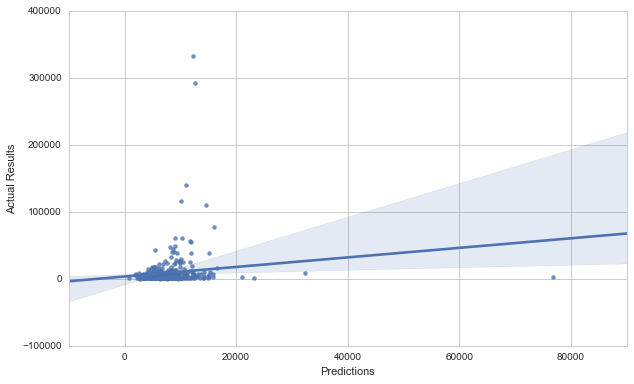

In [57]:
# Plotting 2015 model for our actual regression
sns.set(rc = {"figure.figsize":(10, 6)}, style = 'whitegrid')
ax = sns.regplot(x = lrpred, y = lractual)

ax.set(xlabel = 'Predictions', ylabel = 'Actual Results')

plt.show()

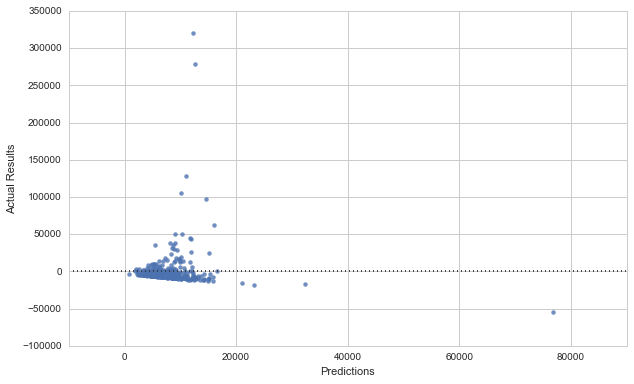

In [59]:
# """Plotting 2015 model's lasso regression"""
sns.set(rc = {"figure.figsize": (10, 6)}, style = 'whitegrid')
ax = sns.residplot(x = lrpred, y = lractual)

ax.set(xlabel = 'Predictions', ylabel = 'Actual Results')

plt.show()

# Present the Results

Present your conclusions and results. If you have more than one interesting model feel free to include more than one along with a discussion. Use your work in this notebook to prepare your write-up.